KeyError: 'quality_score'

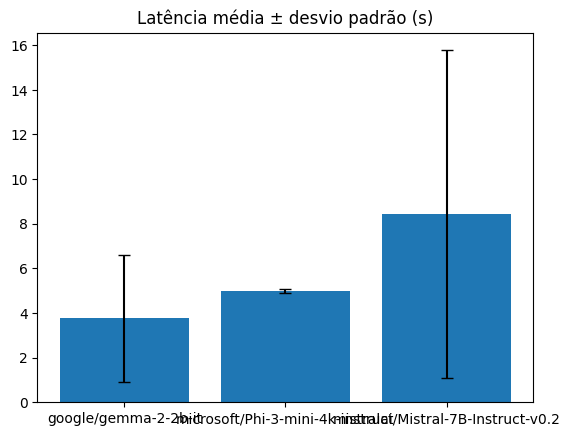

In [3]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

# carregar métricas
metric_files = glob.glob("../results/*_metrics.csv")
dfs = [pd.read_csv(f) for f in metric_files]
metrics = pd.concat(dfs, ignore_index=True)

quality_files = glob.glob("../results/*_quality.csv")
qdfs = [pd.read_csv(f) for f in quality_files]
quality = pd.concat(qdfs, ignore_index=True)

# agrega por modelo
agg = metrics.groupby("model_id").agg(
    latency_mean=("latency_s", "mean"),
    latency_std=("latency_s", "std"),
    tokens_per_s_mean=("tokens_per_s", "mean"),
    vram_gb_peak_mean=("vram_gb_peak", "max")
).reset_index()

plt.bar(agg["model_id"], agg["latency_mean"], yerr=agg["latency_std"], capsize=4)
plt.title("Latência média ± desvio padrão (s)")

agg["score_efficiency"] = agg["tokens_per_s_mean"] / agg["vram_gb_peak_mean"]
agg["score_global"] = (
    0.4*(1/agg["latency_mean"]) +
    0.3*agg["tokens_per_s_mean"] +
    0.3*agg["quality_score"]
)
agg.sort_values("score_global", ascending=False)


In [ ]:
import torch, transformers
env = {
    "gpu": torch.cuda.get_device_name(0),
    "vram_gb": round(torch.cuda.get_device_properties(0).total_memory/1024**3,2),
    "torch": torch.__version__,
    "transformers": transformers.__version__
}
with open("../results/env_metadata.json","w") as f: json.dump(env,f, indent=2)

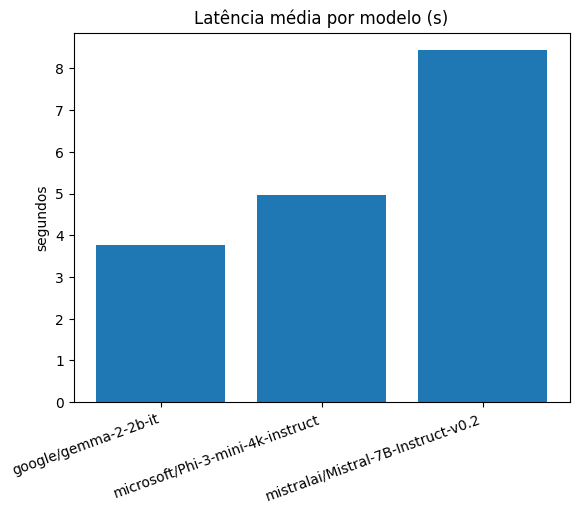

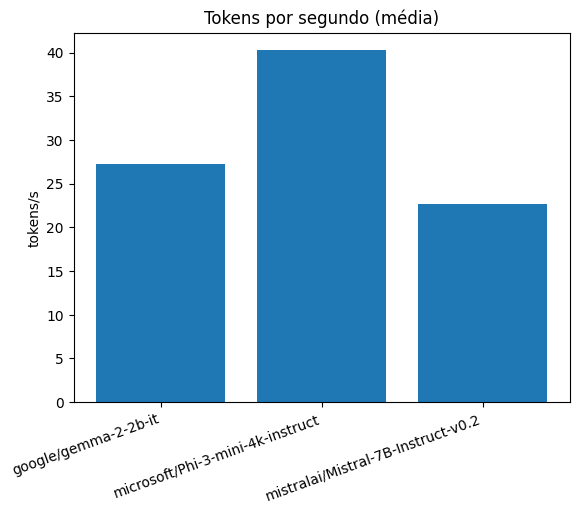

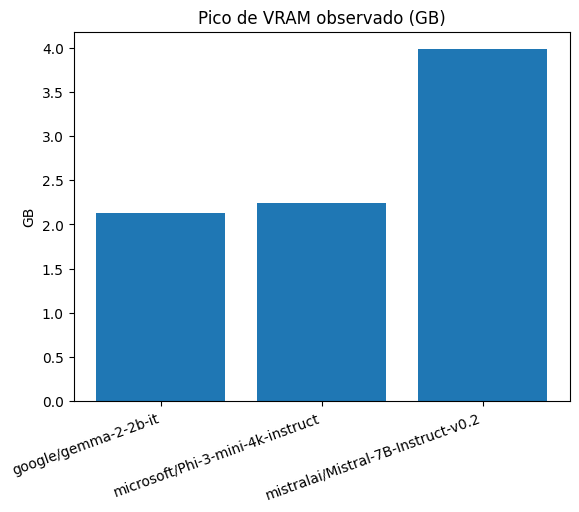

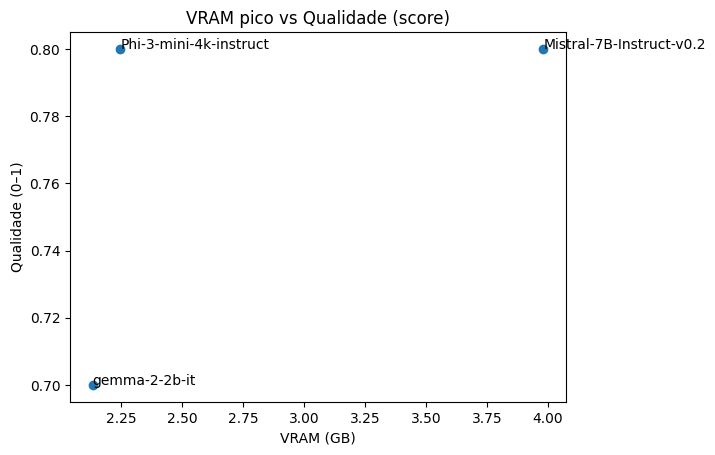

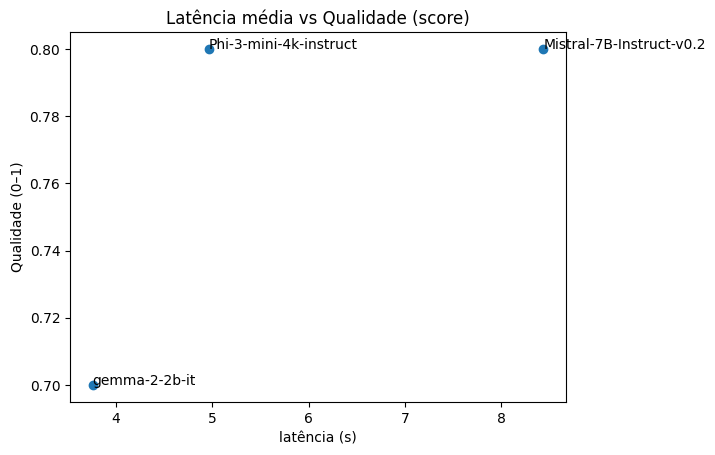

In [2]:
# Tempo médio (s) por modelo
plt.figure()
plt.bar(agg["model_id"], agg["latency_s_mean"])
plt.title("Latência média por modelo (s)")
plt.xticks(rotation=20, ha="right")
plt.ylabel("segundos")
plt.show()

# Tokens/s (throughput)
plt.figure()
plt.bar(agg["model_id"], agg["tokens_per_s_mean"])
plt.title("Tokens por segundo (média)")
plt.xticks(rotation=20, ha="right")
plt.ylabel("tokens/s")
plt.show()

# Pico de VRAM (GB)
plt.figure()
plt.bar(agg["model_id"], agg["vram_gb_peak_mean"])
plt.title("Pico de VRAM observado (GB)")
plt.xticks(rotation=20, ha="right")
plt.ylabel("GB")
plt.show()

# Dispersão: VRAM x Qualidade
plt.figure()
plt.scatter(agg["vram_gb_peak_mean"], agg["quality_score"])
for i, row in agg.iterrows():
    plt.annotate(row["model_id"].split("/")[-1], (row["vram_gb_peak_mean"], row["quality_score"]))
plt.title("VRAM pico vs Qualidade (score)")
plt.xlabel("VRAM (GB)")
plt.ylabel("Qualidade (0–1)")
plt.show()

# Dispersão: Latência x Qualidade
plt.figure()
plt.scatter(agg["latency_s_mean"], agg["quality_score"])
for i, row in agg.iterrows():
    plt.annotate(row["model_id"].split("/")[-1], (row["latency_s_mean"], row["quality_score"]))
plt.title("Latência média vs Qualidade (score)")
plt.xlabel("latência (s)")
plt.ylabel("Qualidade (0–1)")
plt.show()


In [ ]:
from math import pi
import numpy as np, matplotlib.pyplot as plt

cols = ["latency_mean","tokens_per_s_mean","quality_score","vram_gb_peak_mean"]
labels = ["Latência (↓)", "Tokens/s (↑)", "Qualidade (↑)", "VRAM (↓)"]
values = agg.loc[agg["model_id"]=="microsoft/Phi-3-mini-4k-instruct", cols].values.flatten()

angles = np.linspace(0, 2*np.pi, len(cols), endpoint=False).tolist()
values = np.concatenate((values, [values[0]]))
angles += angles[:1]

plt.polar(angles, values)
plt.fill(angles, values, alpha=0.25)
plt.title("Perfil de desempenho — Phi-3 Mini")
plt.show()

Resumo consolidado:



,model_id,latency_s_mean,tokens_per_s_mean,vram_gb_peak_mean,new_tokens_mean,quality_score,efficiency
0,microsoft/Phi-3-mini-4k-instruct,4.966508,40.281232,2.246726,200.000000,0.800000,14.343089
1,mistralai/Mistral-7B-Instruct-v0.2,8.438876,22.694654,3.982201,143.000000,0.800000,4.559218
2,google/gemma-2-2b-it,3.756823,27.252107,2.132290,103.100000,0.700000,8.946473


C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:45: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:45: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


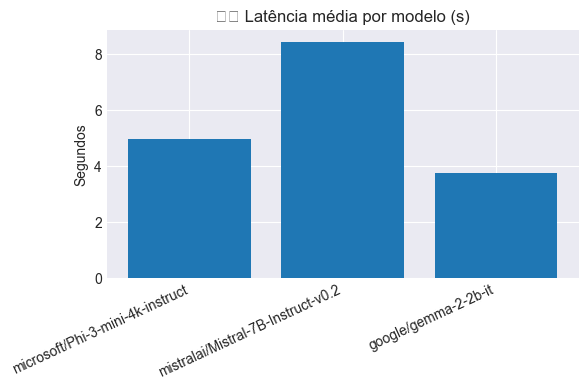

C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:54: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


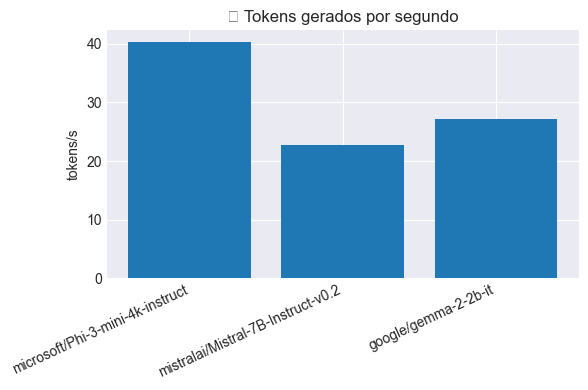

C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:63: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) Arial.
  plt.tight_layout()
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128190 (\N{FLOPPY DISK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


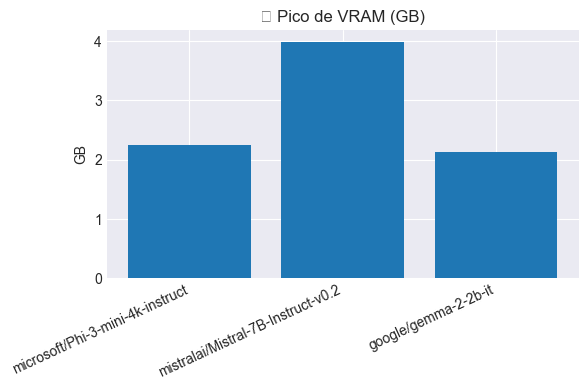

C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:72: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  plt.tight_layout()
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


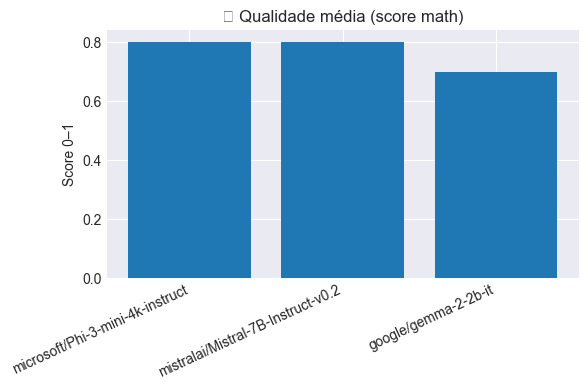

C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:81: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


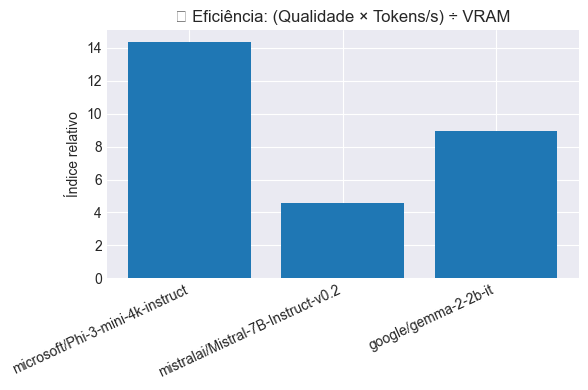

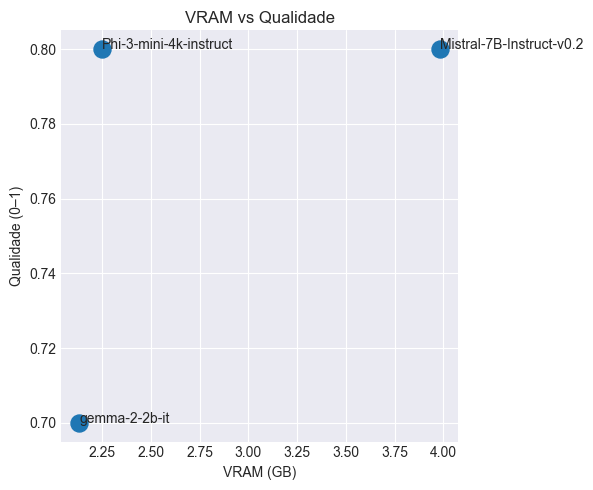

C:\Users\marce\AppData\Local\Temp\ipykernel_10336\608314702.py:126: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
i:\small-models-benchmark\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


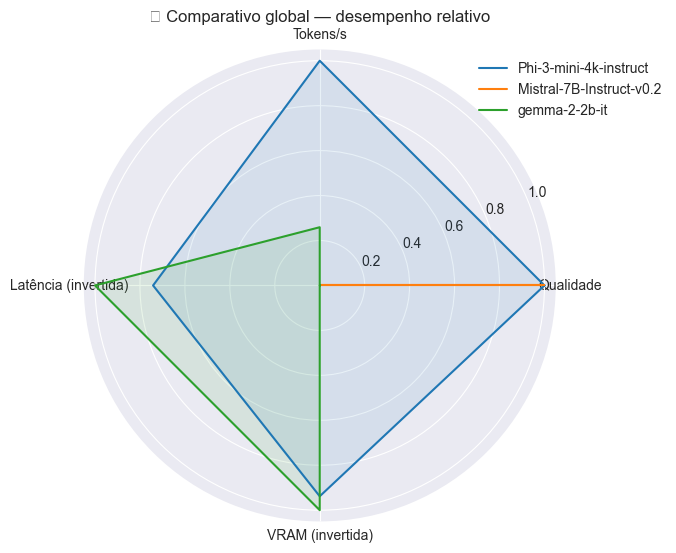

In [5]:
# === Compare & Plot Benchmark Results ===
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

plt.style.use("seaborn-v0_8-darkgrid")

# ---------- Load Metrics ----------
metric_files = glob.glob("../results/*_metrics.csv")
quality_files = glob.glob("../results/*_quality.csv")

dfs = [pd.read_csv(f) for f in metric_files]
metrics = pd.concat(dfs, ignore_index=True)

qdfs = [pd.read_csv(f) for f in quality_files]
quality = pd.concat(qdfs, ignore_index=True)

# ---------- Aggregate ----------
agg = metrics.groupby("model_id").agg(
    latency_s_mean=("latency_s", "mean"),
    tokens_per_s_mean=("tokens_per_s", "mean"),
    vram_gb_peak_mean=("vram_gb_peak", "max"),
    new_tokens_mean=("new_tokens", "mean"),
).reset_index()

agg = agg.merge(quality[["model_id", "quality_score"]], on="model_id", how="left")

agg = agg.sort_values(by="quality_score", ascending=False).reset_index(drop=True)
agg["efficiency"] = agg["quality_score"] * agg["tokens_per_s_mean"] / agg["vram_gb_peak_mean"]

print("Resumo consolidado:\n")
display(agg.style.background_gradient(subset=["quality_score", "tokens_per_s_mean", "efficiency"], cmap="Greens"))

# ---------- Gráficos ----------
def label_rotation():
    plt.xticks(rotation=25, ha="right")

# Latência
plt.figure(figsize=(6,4))
plt.bar(agg["model_id"], agg["latency_s_mean"])
plt.title("⏱️ Latência média por modelo (s)")
plt.ylabel("Segundos")
label_rotation()
plt.tight_layout()
plt.show()

# Tokens/s
plt.figure(figsize=(6,4))
plt.bar(agg["model_id"], agg["tokens_per_s_mean"])
plt.title("⚡ Tokens gerados por segundo")
plt.ylabel("tokens/s")
label_rotation()
plt.tight_layout()
plt.show()

# VRAM
plt.figure(figsize=(6,4))
plt.bar(agg["model_id"], agg["vram_gb_peak_mean"])
plt.title("💾 Pico de VRAM (GB)")
plt.ylabel("GB")
label_rotation()
plt.tight_layout()
plt.show()

# Qualidade
plt.figure(figsize=(6,4))
plt.bar(agg["model_id"], agg["quality_score"])
plt.title("🎯 Qualidade média (score math)")
plt.ylabel("Score 0–1")
label_rotation()
plt.tight_layout()
plt.show()

# Eficiência global
plt.figure(figsize=(6,4))
plt.bar(agg["model_id"], agg["efficiency"])
plt.title("📈 Eficiência: (Qualidade × Tokens/s) ÷ VRAM")
plt.ylabel("Índice relativo")
label_rotation()
plt.tight_layout()
plt.show()

# Trade-off scatter
plt.figure(figsize=(6,5))
plt.scatter(agg["vram_gb_peak_mean"], agg["quality_score"], s=150)
for i, row in agg.iterrows():
    plt.annotate(row["model_id"].split("/")[-1], (row["vram_gb_peak_mean"], row["quality_score"]))
plt.title("VRAM vs Qualidade")
plt.xlabel("VRAM (GB)")
plt.ylabel("Qualidade (0–1)")
plt.tight_layout()
plt.show()

# Radar chart
labels = ["Qualidade", "Tokens/s", "Latência (invertida)", "VRAM (invertida)"]
models = agg["model_id"].tolist()

# Normalização 0–1
norm = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-9)
quality_norm = norm(agg["quality_score"])
tokens_norm = norm(agg["tokens_per_s_mean"])
latency_norm = 1 - norm(agg["latency_s_mean"])
vram_norm = 1 - norm(agg["vram_gb_peak_mean"])

# Monta matriz (n_features x n_models)
data = np.vstack([quality_norm, tokens_norm, latency_norm, vram_norm])

# Ângulos para cada métrica
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # fecha o círculo

plt.figure(figsize=(7,7))
ax = plt.subplot(111, polar=True)

# Plota cada modelo individualmente
for i, model in enumerate(models):
    values = np.concatenate((data[:, i], [data[0, i]]))  # fecha o loop
    ax.plot(angles, values, label=model.split("/")[-1])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title("📊 Comparativo global — desempenho relativo", pad=20)
plt.legend(bbox_to_anchor=(1.25, 1.0))
plt.tight_layout()
plt.show()